### Demonstrate model prediction bias, variance, and the bias-variance trade-off

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Altering defaults (mostly to change font size in figures)

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [5.0, 4.0]
mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['figure.titlesize'] = 'medium'

### Define the "true signal" that sets house price based on size

In [3]:
size = np.arange(500, 5500, 500)
price_true = -1.2e6 + 2.5e5 * np.log(size) # no irreducible error (yet)

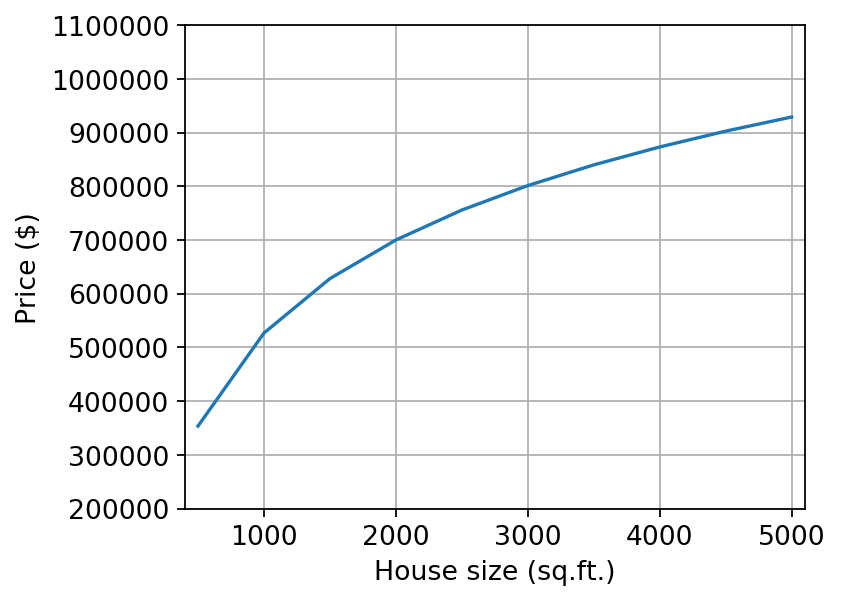

In [4]:
fig, ax = plt.subplots()
ax.plot(size, price_true)
ax.set_xlabel('House size (sq.ft.)')
ax.set_ylabel('Price ($)')
ax.set_xlim((400, 5100))
ax.set_ylim((200000, 1100000))
ax.grid()

### But there is some irreducible error associated with getting samples from this true function

In [5]:
sigma = 75000 # standard deviation of data sampled from true value

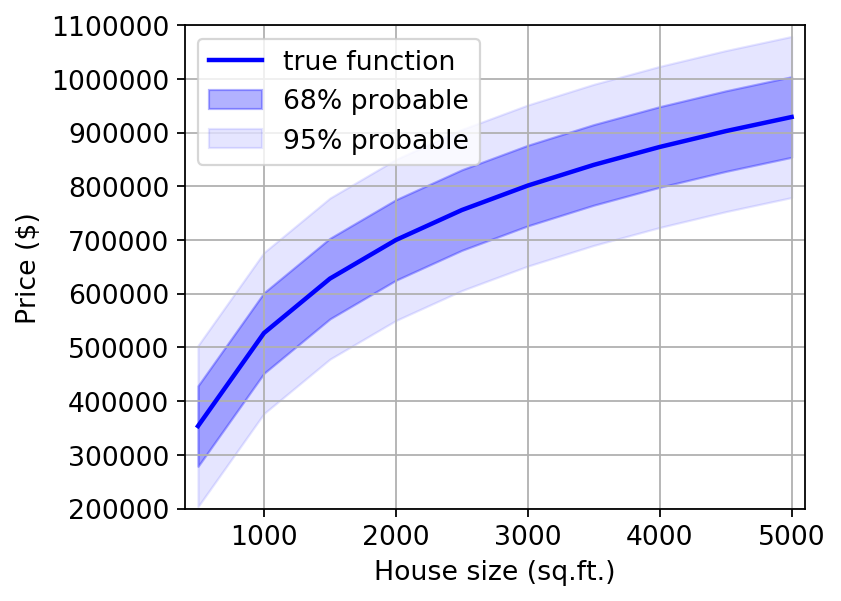

In [6]:
fig, ax = plt.subplots()
ax.plot(size, price_true, color='b', lw=2, label='true function')
ax.fill_between(size, price_true - sigma, price_true + sigma, alpha=0.3, color='b', label='68% probable')
ax.fill_between(size, price_true - 2*sigma, price_true + 2*sigma, alpha=0.1, color='b', label='95% probable')
ax.set_xlabel('House size (sq.ft.)')
ax.set_ylabel('Price ($)');
ax.set_xlim((400, 5100))
ax.set_ylim((200000, 1100000))
ax.legend()
ax.grid();

### Let's draw some samples from this distribution to train our model on

In [7]:
from scipy import stats
epsilon = stats.norm(loc=0, scale=sigma)

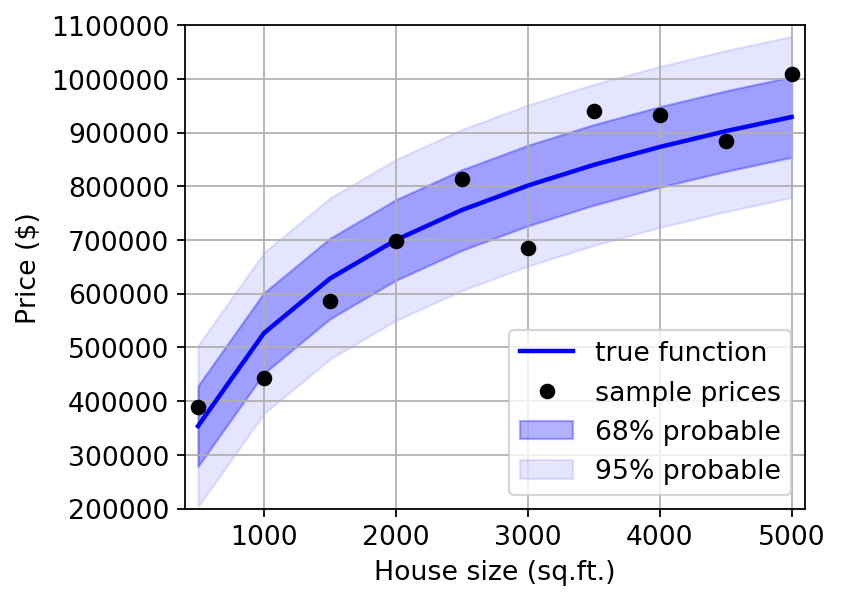

In [8]:
# find errors for each price
epsilons = epsilon.rvs(size=len(price_true))
price_sample = price_true + epsilons

fig, ax = plt.subplots()
ax.plot(size, price_true, color='b', lw=2, label='true function')
ax.plot(size, price_sample, 'ko', label='sample prices')
ax.fill_between(size, price_true - sigma, price_true + sigma, alpha=0.3, color='b', label='68% probable')
ax.fill_between(size, price_true - 2*sigma, price_true + 2*sigma, alpha=0.1, color='b', label='95% probable')
ax.set_xlabel('House size (sq.ft.)')
ax.set_ylabel('Price ($)');
ax.set_xlim((400, 5100))
ax.set_ylim((200000, 1100000))
ax.legend()
ax.grid();

#### Let's make 9 sample populations to train our models on

In [9]:
num_sample_pop = 9 # 4, 16 also options
epsilons = epsilon.rvs(size=(num_sample_pop,len(price_true)))
prices = price_true + epsilons # whoa numpy

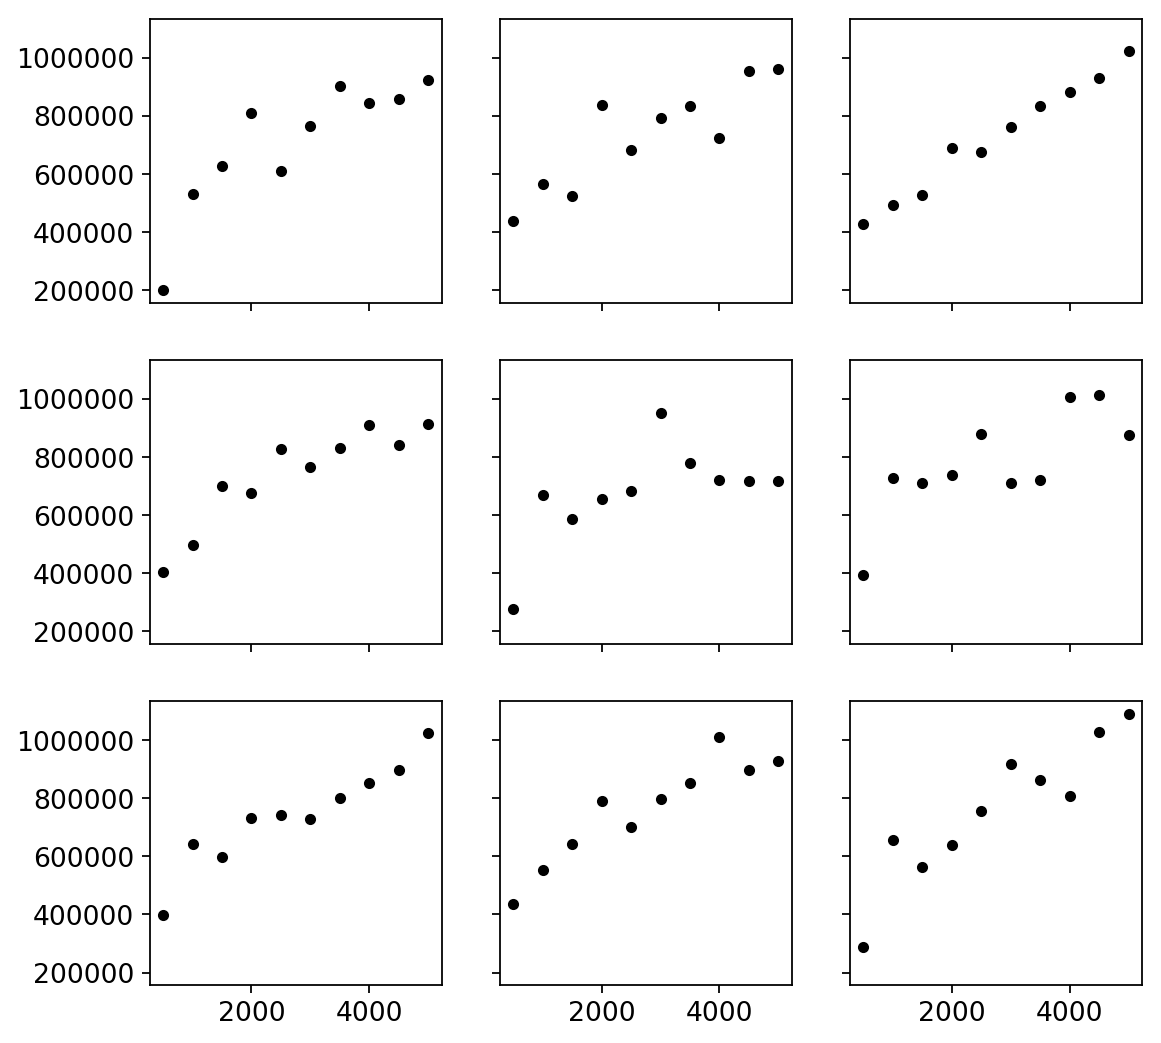

In [10]:
nrows = int(np.sqrt(num_sample_pop))
ncols = nrows
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8), sharex=True, sharey=True)
i = 0
for r in range(nrows):
    for c in range(ncols):
        axes[r,c].plot(size, prices[i], 'ko', ms=4)
        i += 1
# unsure if this is best way to do this, but it's simple

### Let's start fitting models of different complexity to this training data

In [11]:
sizes_fine = np.linspace(min(size),max(size),100, endpoint=True)

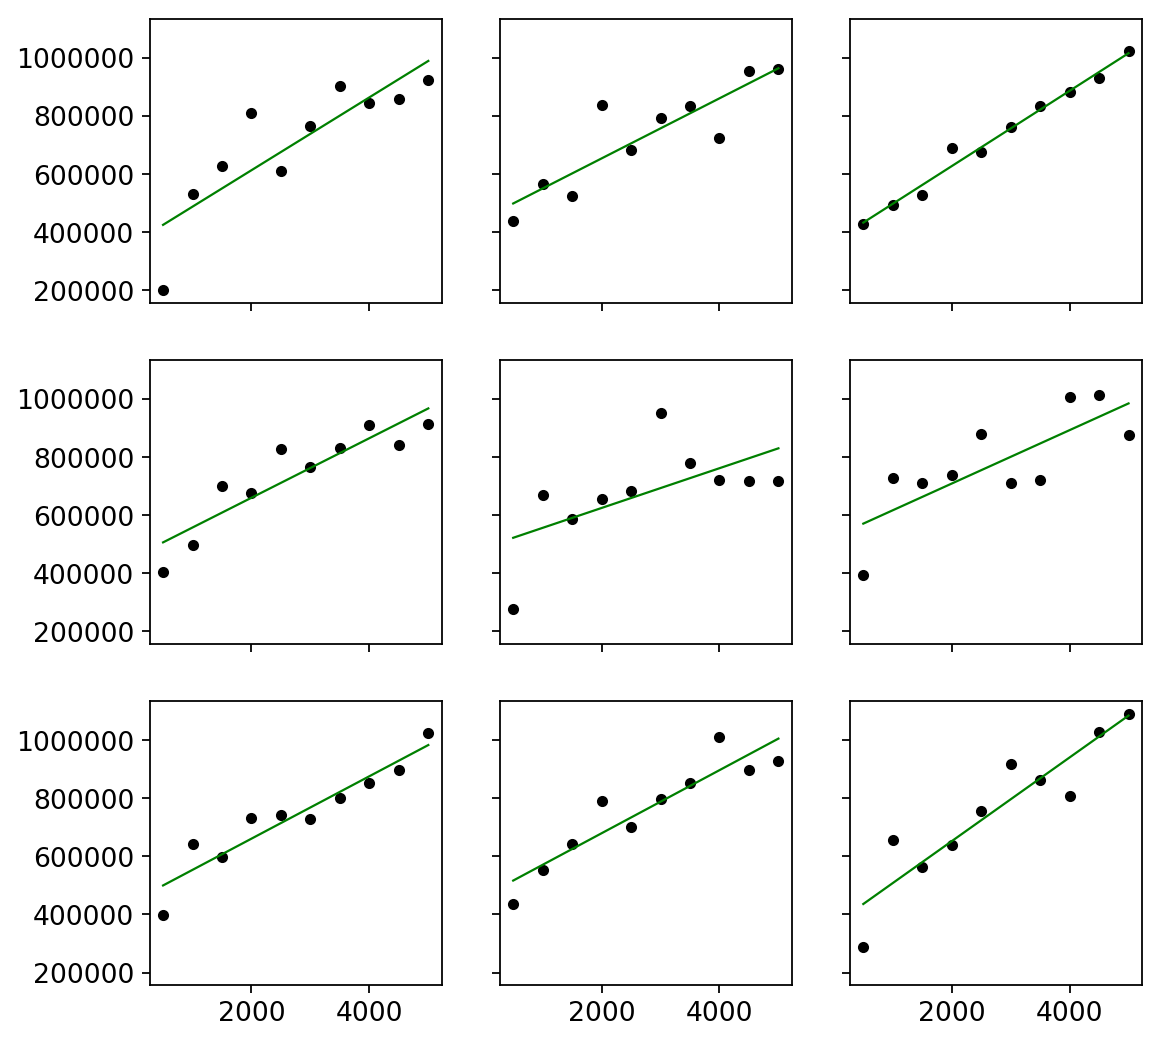

In [12]:
deg = 1 # first order fit, i.e. p = b0 + b1*s
betas = [np.polyfit(size, price,deg=deg) for price in prices]
preds_fine = [np.polyval(beta,sizes_fine) for beta in betas]

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8), sharex=True, sharey=True)
i = 0
for r in range(nrows):
    for c in range(ncols):
        axes[r,c].plot(size, prices[i], 'ko', ms=4)
        axes[r,c].plot(sizes_fine, preds_fine[i], 'g-', lw=1)
        i += 1

#### Plot the predictions at a set house size for each model and compare to the true value

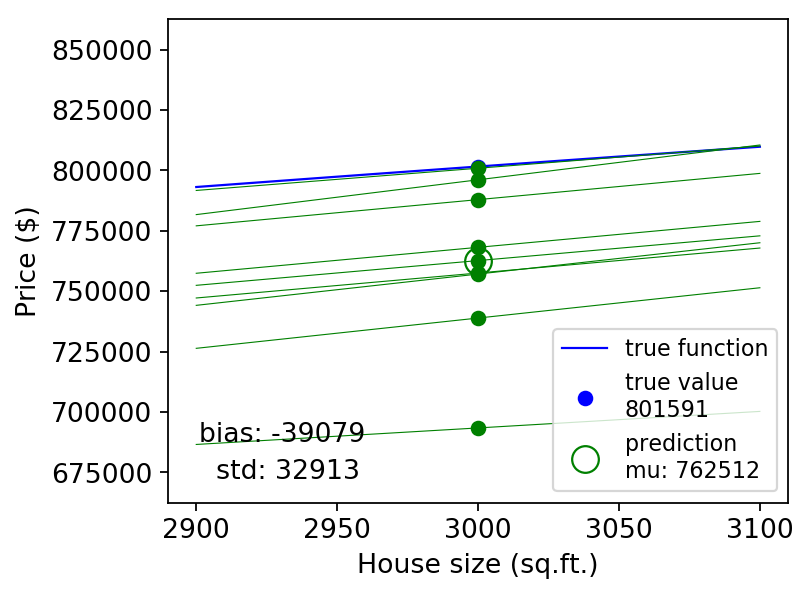

In [13]:
onesize = 3000 # sq.ft.
price_onesize_true = -1.2e6 + 2.5e5 * np.log(onesize)
preds_onesize = [np.polyval(beta,[onesize]) for beta in betas]

pred_expected = np.array(preds_onesize).mean()
pred_std = np.array(preds_onesize).std(ddof=1)

bias = pred_expected - price_onesize_true

sizerange = np.linspace(onesize-100, onesize+100, 100, endpoint=True)
price_range_true = -1.2e6 + 2.5e5 * np.log(sizerange)
preds_range = [np.polyval(beta,sizerange) for beta in betas]

lbl_tv = "true value\n{0}".format(int(price_onesize_true))
lbl_pred = "prediction\nmu: {0}".format(int(pred_expected))
lbl_bias = "bias: {0}".format(int(bias))
lbl_std = "  std: {0}".format(int(pred_std))

fig, ax = plt.subplots()
ax.plot(sizerange, price_range_true, color='b', lw=1, label='true function')
ax.plot([onesize], [price_onesize_true], 'bo', label=lbl_tv)
ax.plot([onesize], [pred_expected], 'go', ms=12, mfc='white', label=lbl_pred)
for i in range(len(preds_onesize)):
    ax.plot([onesize],[preds_onesize[i]], 'go')
    ax.plot(sizerange, preds_range[i], color='g', lw=0.5)
ax.set_xlabel('House size (sq.ft.)')
ax.set_ylabel('Price ($)')
ax.set_ylim((pred_expected-100000, pred_expected+100000))
ax.text(min(sizerange)+1, pred_expected-75000, lbl_bias)
ax.text(min(sizerange)+1, pred_expected-90000, lbl_std)
ax.legend(fontsize=10);

### The first order fit was systematically off from the true value - its predictions showed High Bias, but not much variance.

### Now let's examine a more complex model (a higher order fit)

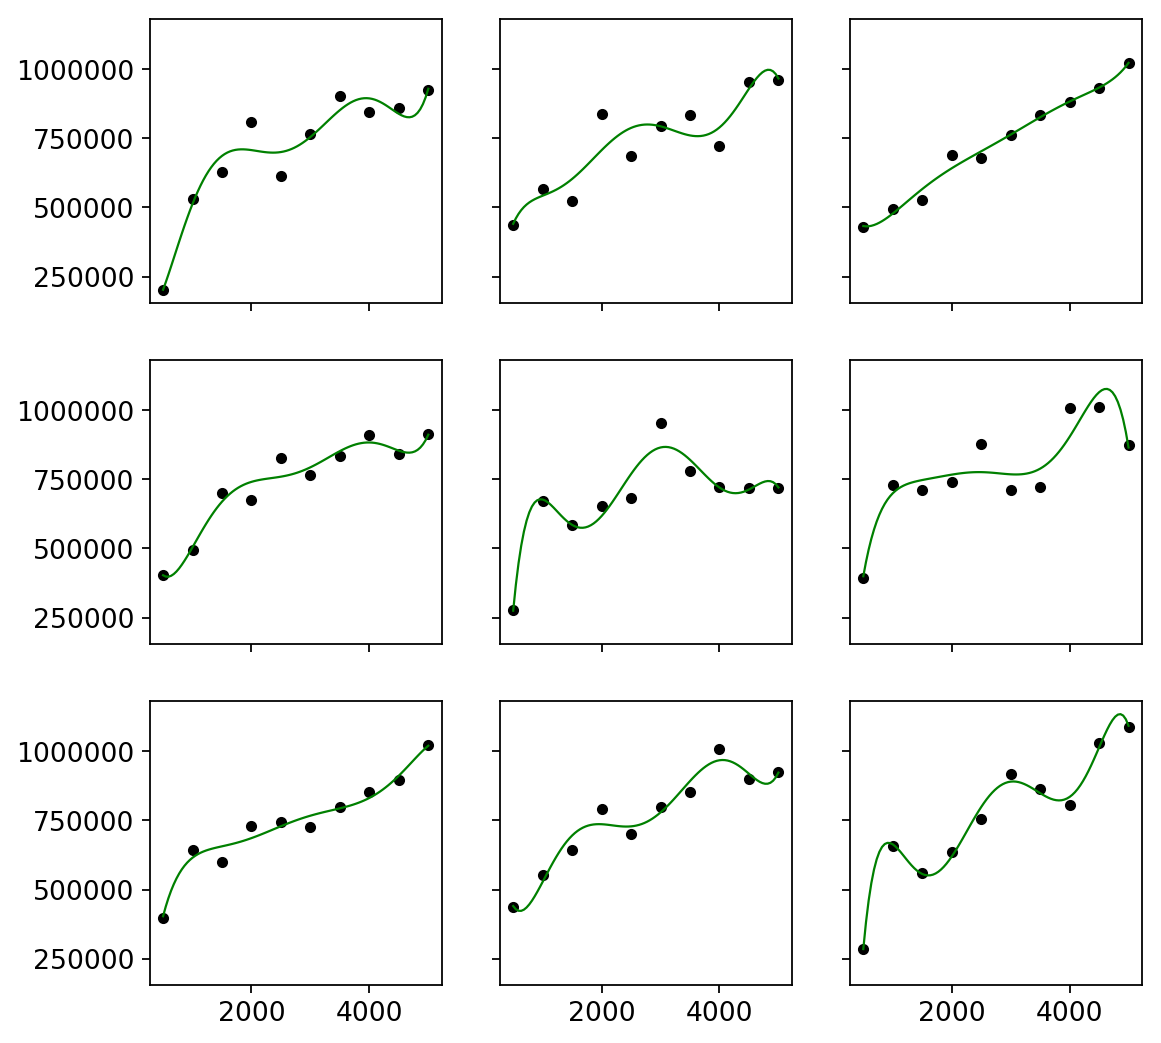

In [14]:
deg = 6 # sixth order polynomial
betas = [np.polyfit(size, price,deg=deg) for price in prices]
preds_fine = [np.polyval(beta,sizes_fine) for beta in betas]

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8), sharex=True, sharey=True)
i = 0
for r in range(nrows):
    for c in range(ncols):
        axes[r,c].plot(size, prices[i], 'ko', ms=4)
        axes[r,c].plot(sizes_fine, preds_fine[i], 'g-', lw=1)
        i += 1

#### Plot the predictions at a set house size for each model and compare to the true value

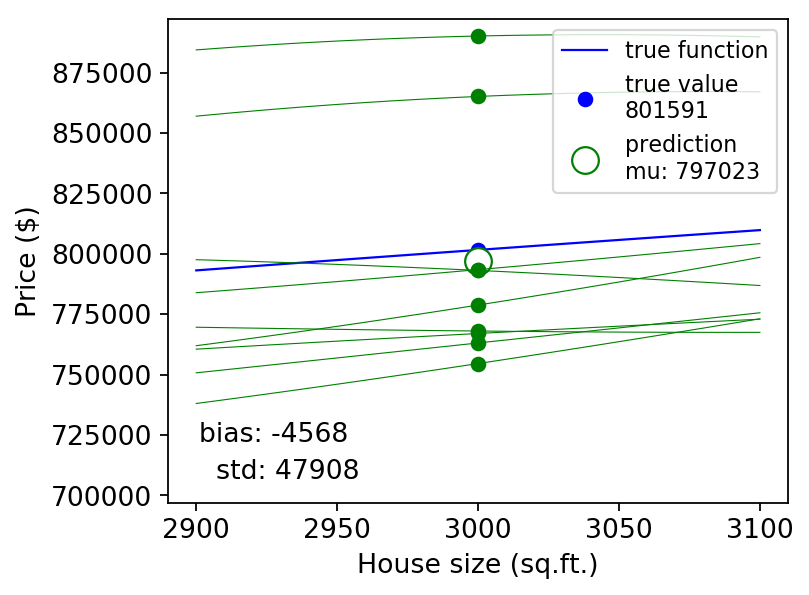

In [15]:
onesize = 3000 # sq.ft.
price_onesize_true = -1.2e6 + 2.5e5 * np.log(onesize)
preds_onesize = [np.polyval(beta,[onesize]) for beta in betas]

pred_expected = np.array(preds_onesize).mean()
pred_std = np.array(preds_onesize).std(ddof=1)

bias = pred_expected - price_onesize_true

sizerange = np.linspace(onesize-100, onesize+100, 100, endpoint=True)
price_range_true = -1.2e6 + 2.5e5 * np.log(sizerange)
preds_range = [np.polyval(beta,sizerange) for beta in betas]

lbl_tv = "true value\n{0}".format(int(price_onesize_true))
lbl_pred = "prediction\nmu: {0}".format(int(pred_expected))
lbl_bias = "bias: {0}".format(int(bias))
lbl_std = "  std: {0}".format(int(pred_std))

fig, ax = plt.subplots()
ax.plot(sizerange, price_range_true, color='b', lw=1, label='true function')
ax.plot([onesize], [price_onesize_true], 'bo', label=lbl_tv)
ax.plot([onesize], [pred_expected], 'go', ms=12, mfc='white', label=lbl_pred)
for i in range(len(preds_onesize)):
    ax.plot([onesize],[preds_onesize[i]], 'go')
    ax.plot(sizerange, preds_range[i], color='g', lw=0.5)
ax.set_xlabel('House size (sq.ft.)')
ax.set_ylabel('Price ($)')
ax.set_ylim((pred_expected-100000, pred_expected+100000))
ax.text(min(sizerange)+1, pred_expected-75000, lbl_bias)
ax.text(min(sizerange)+1, pred_expected-90000, lbl_std)
ax.legend(fontsize=10);

### The sixth order fit showed less bias than the first order fit, but more variance.  It's predictions have High Variance.

### Takeaway:  As you increase model complexity (higher order fit, or more features, etc.) to fit training data, you'll be able to fit the data better, but you also become more sensitive to noise in the data.  Therefore as model complexity goes from simple to more complex, you'll likely transition from a model that gives high bias, low variance predictions to a model that gives low bias, higher variance predictions.

### The goal is to find the complexity sweet spot that has the lowest combination of bias and variance.